# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports,-Definitions" data-toc-modified-id="Imports,-Definitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports, Definitions</a></div><div class="lev1 toc-item"><a href="#Dijkstra" data-toc-modified-id="Dijkstra-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dijkstra</a></div><div class="lev1 toc-item"><a href="#A*" data-toc-modified-id="A*-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A*</a></div>

[Draw a Map][map]

[map]: https://neighthan.github.io/graphs_and_games/create_map.html

# Imports, Definitions

In [1]:
import numpy as np
import pandas as pd
import heapq
from ast import literal_eval
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import namedtuple

%matplotlib inline

In [2]:
grid_cell_types = ['WALL', 'NORMAL', 'START', 'GOAL', 'FRINGE', 'EXPANDED']
grid_colors = ['black', 'white', 'green', 'red', 'lightblue', 'blue']

cmap = ListedColormap(grid_colors)

# don't worry about this part; just for fancy dotted access
GridValues = namedtuple('GridValues', grid_cell_types)
GridValue = namedtuple('GridValue', ['value', 'name', 'color'])
grid = GridValues(*[GridValue(i, grid_cell_types[i], grid_colors[i]) for i in range(len(grid_colors))])


terrain_types = ['ROAD', 'GRASSY', 'FOREST', 'ROCKY']
terrain_colors = ['sandybrown', 'lightgreen', 'darkgreen', 'grey']

terrain_cmap = ListedColormap(terrain_colors)

# don't worry about this part; just for fancy dotted access
TerrainValues = namedtuple('GridValues', terrain_types)
TerrainValue = namedtuple('GridValue', ['value', 'name', 'color'])
terrain_values = TerrainValues(*[TerrainValue(i, terrain_types[i], terrain_colors[i]) for i in range(len(terrain_colors))])

In [3]:
def create_map():
    grid = np.array(literal_eval(input('Paste map data here')))
    display.clear_output()
    return grid


def show_maze(maze):
    plt.figure(figsize=(20, 10))
    img = plt.matshow(maze, cmap=cmap, vmin=-0.5, vmax=len(grid_colors)-0.5, fignum=1)
    cbar = plt.colorbar(ticks=np.arange(0, len(grid_colors)))
    cbar.set_ticklabels(grid_cell_types)


def show_terrain(terrain):
    unique_vals = np.unique(terrain)
    terrain = pd.DataFrame(terrain).replace({unique_vals[i]: i for i in range(len(unique_vals))}).values
    
    plt.figure(figsize=(20, 10))
    img = plt.matshow(terrain, cmap=terrain_cmap, fignum=1, vmin=-0.5, vmax=len(terrain_types)-0.5)
    cbar = plt.colorbar(ticks=np.arange(0, len(terrain_types)))
    cbar.set_ticklabels(terrain_types)

In [4]:
terrain = create_map()

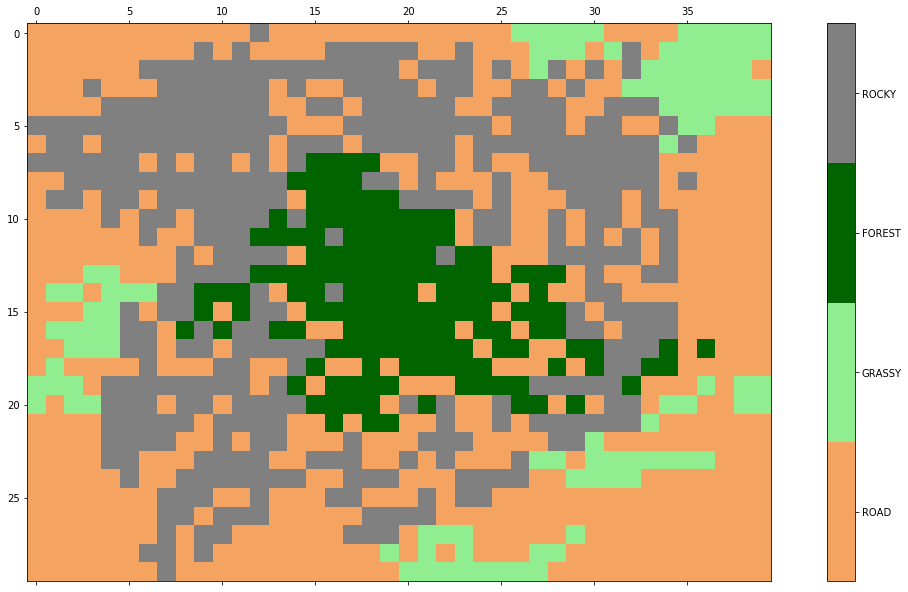

In [5]:
show_terrain(terrain)

In [ ]:
# save a couple of maps to disk? with some names so you can reload the ones you want
[[5,5,5,5,5,5,5,5,5,5,5,5,18,5,5,5,5,5,5,5,5,5,5,5,5,5,8,8,8,8,8,5,5,5,5,8,8,8,8,8],[5,5,5,5,5,5,5,5,5,18,5,18,5,5,5,5,18,18,18,18,18,5,5,18,5,5,5,8,8,8,5,8,18,5,8,8,8,8,8,8],[5,5,5,5,5,5,18,18,18,18,18,18,18,18,18,18,18,18,18,18,5,18,18,18,5,18,5,8,18,5,18,5,18,8,8,8,8,8,8,5],[5,5,5,18,5,5,5,18,18,18,18,18,18,5,18,5,5,18,18,18,18,5,18,18,5,5,18,18,5,18,5,5,8,8,8,8,8,8,8,8],[5,5,5,5,18,18,18,18,18,18,18,18,18,5,5,18,18,5,18,18,18,18,18,5,5,18,18,18,18,5,5,18,18,18,8,8,8,8,8,8],[18,18,18,18,18,18,18,18,18,18,18,18,18,18,5,5,5,18,18,18,18,18,18,18,18,5,18,18,18,5,18,18,5,5,18,8,8,5,5,5],[5,18,18,5,18,18,18,18,18,18,18,18,18,5,18,18,18,5,18,18,18,18,18,5,18,18,18,18,18,18,18,18,18,18,8,18,5,5,5,5],[18,18,18,18,18,18,5,18,5,18,18,5,18,5,18,13,13,13,13,5,5,18,18,5,18,5,5,18,18,18,18,18,18,18,5,5,5,5,5,5],[5,5,18,18,18,18,18,18,18,18,18,18,18,18,13,13,13,13,18,18,5,18,5,5,5,18,5,5,18,18,18,18,18,18,5,18,5,5,5,5],[5,18,18,5,18,18,5,18,18,18,18,18,18,18,5,13,13,13,13,13,18,18,18,18,5,18,5,5,5,18,18,18,5,18,5,5,5,5,5,5],[5,5,5,5,18,5,18,18,5,18,18,18,18,13,18,13,13,13,13,13,13,13,13,5,18,18,5,5,18,5,18,18,5,18,18,5,5,5,5,5],[5,5,5,5,5,5,18,5,5,18,18,18,13,13,13,13,18,13,13,13,13,13,13,5,18,18,5,5,18,5,18,5,18,5,18,5,5,5,5,5],[5,5,5,5,5,5,5,5,18,5,18,18,18,18,5,13,13,13,13,13,13,13,18,13,13,5,5,5,18,18,18,18,18,5,18,5,5,5,5,5],[5,5,5,8,8,5,5,5,18,18,18,18,13,13,13,13,13,13,13,13,13,13,13,13,13,5,13,13,13,5,18,5,5,18,18,5,5,5,5,5],[5,8,8,5,8,8,8,18,18,13,13,13,18,5,13,13,18,13,13,13,13,5,13,13,13,13,5,13,5,5,18,18,5,5,5,5,5,5,5,5],[5,5,5,8,8,18,5,18,18,13,5,13,18,18,5,13,13,13,13,13,13,13,13,13,13,5,13,13,13,18,5,18,18,18,18,5,5,5,5,5],[5,8,8,8,8,18,18,5,13,18,13,18,18,13,13,5,5,13,13,13,13,13,13,5,13,13,5,13,13,18,18,5,18,18,18,5,5,5,5,5],[5,5,8,8,8,18,18,5,18,18,5,18,18,18,18,18,13,13,13,13,13,13,13,13,5,13,13,5,5,13,13,18,18,18,13,5,13,5,5,5],[5,8,5,5,5,5,18,5,5,5,18,18,5,5,18,13,5,5,13,5,13,13,13,13,13,5,5,5,13,5,13,18,18,13,13,5,5,5,5,5],[8,8,8,5,18,18,18,18,18,18,18,18,5,18,13,5,13,13,13,13,5,5,5,13,13,13,13,18,18,18,18,18,13,5,5,5,8,5,8,8],[8,5,8,8,18,18,18,5,18,18,5,18,18,18,18,13,13,13,13,5,18,13,18,5,5,18,13,13,5,13,5,18,18,5,8,8,5,5,8,8],[5,5,5,5,18,18,18,18,18,5,18,18,18,18,5,5,13,5,13,13,5,5,18,5,5,18,5,18,18,18,18,18,18,8,5,5,5,5,5,5],[5,5,5,5,18,18,18,18,5,5,18,5,18,18,5,5,5,18,5,5,5,18,18,18,5,5,5,5,18,18,8,5,5,5,5,5,5,5,5,5],[5,5,5,5,18,18,5,5,5,18,18,18,18,5,5,18,18,18,5,5,18,5,18,5,5,5,18,8,8,5,8,8,8,8,8,8,8,5,5,5],[5,5,5,5,5,18,5,5,18,18,18,18,18,18,18,5,5,18,18,18,5,5,5,18,18,18,18,5,5,8,8,8,8,5,5,5,5,5,5,5],[5,5,5,5,5,5,5,18,18,18,5,5,18,5,5,5,18,18,5,5,5,18,5,18,18,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],[5,5,5,5,5,5,5,18,18,5,18,18,18,5,5,5,5,5,18,18,18,18,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],[5,5,5,5,5,5,5,18,5,18,18,5,5,5,5,5,5,18,18,18,5,8,8,8,5,5,5,5,5,8,5,5,5,5,5,5,5,5,5,5],[5,5,5,5,5,5,18,18,5,18,5,5,5,5,5,5,5,5,5,8,5,8,5,8,5,5,5,8,8,5,5,5,5,5,5,5,5,5,5,5],[5,5,5,5,5,5,5,18,5,5,5,5,5,5,5,5,5,5,5,5,8,8,8,8,8,8,8,8,5,5,5,5,5,5,5,5,5,5,5,5]]

# Dijkstra

Dijkstra's algorithm only works on graphs with non-negative weights. There are other algorithms that you can use instead of any of the edge's might have a negative weight.

Read about heapq usage here: https://docs.python.org/2/library/heapq.html

In [13]:
def dijkstra(grid, start, goal):
    pass

# A\*

In [14]:
def a_star(grid, start, goal):
    pass